# Benchmark Algo on a simple problem
Minimizing the sinus between 0 and 2pi leads to 2pi / 3

In [1]:
# https://stackoverflow.com/questions/53217771/jupyter-making-3d-matplotlib-graphs-extremely-small
%matplotlib inline
import sys
sys.path.append("../")
from base import benchmark_simple
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot

In [2]:
optimization_problem = [
    {
        "name": "x",
        "category": "uniform",
        "search_space": {
            "low": 0,
            "high": 2 * np.pi,
        }
    },
    {
        "name": "y",
        "category": "uniform",
        "search_space": {
            "low": 0,
            "high": 2 * np.pi,
        }
    },
]


def function_to_optimize(x, y):
    return np.cos(x) + np.cos(y) + np.cos(2 * x + 1)

x = np.linspace(0, 2 * np.pi, 200)
y = np.linspace(0, 2 * np.pi, 200)
X, Y = np.meshgrid(x, y)
zs = np.array([function_to_optimize(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
x_target, y_target = list(zip(np.ravel(X), np.ravel(Y)))[np.argmin(zs)]
target = {"x": x_target, "y": y_target}

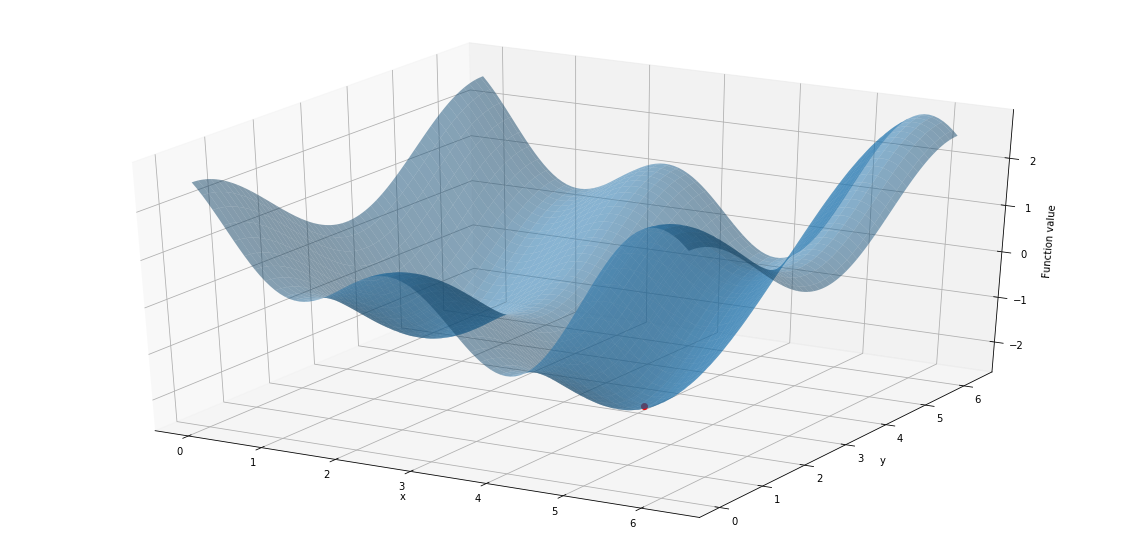

In [3]:
# plot target function
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

x = np.linspace(0, 2 * np.pi, 100)
y = np.linspace(0, 2 * np.pi, 100)
X, Y = np.meshgrid(x, y)
zs = np.array([function_to_optimize(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, alpha=0.5)
ax.plot([target["x"]], [target["y"]], [function_to_optimize(**target)], color="r", marker="o", alpha=1, lw=3)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Function value')

plt.show()

In [4]:
seeds = list(range(30))

methods = ["random", "parzen_estimator"]

number_of_evaluations = [5, 10, 20, 30, 35, 40, 45, 50, 55, 60, 70, 80, 100]

In [5]:
results = benchmark_simple(
    function_to_optimize=function_to_optimize,
    optimization_problem=optimization_problem,
    target=target,
    methods=methods,
    number_of_evaluations=number_of_evaluations,
    seeds=seeds,
    parallel=True,
)

Number of trials: 780


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 729 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:   20.4s finished


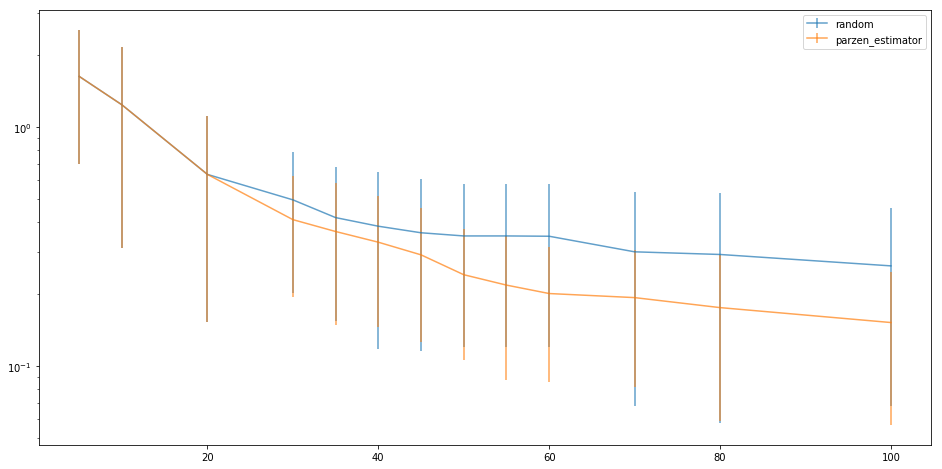

In [6]:
plt.figure(figsize=(16, 8))
for method in methods:
    plt.errorbar(
        x=number_of_evaluations,
        y=[results[method][number_of_evaluation]["mean"] for number_of_evaluation in number_of_evaluations],
        yerr=[results[method][number_of_evaluation]["std"] for number_of_evaluation in number_of_evaluations],
        label=method,
        alpha=0.7
    )
    plt.legend()
    plt.yscale("log")

In [10]:
from matplotlib import animation, rc
from IPython.display import HTML

from benderopt import minimize

def get_animation(number_of_evaluation=70, seed=None):

    lines = []
    samples_list = []
    fig = plt.figure(figsize=(14, 18))
    for k, method in enumerate(methods):
        samples_tmp = minimize(
            f=function_to_optimize,
            optimization_problem=optimization_problem,
            optimizer_type=method,
            number_of_evaluation=number_of_evaluation,
            seed=seed,
            debug=True
        )
        samples = np.array([[sample["x"], sample["y"], function_to_optimize(**sample)]
                                  for sample in samples_tmp]).T
        samples_list.append(samples)

        ax = fig.add_subplot(len(methods), 1, k + 1, projection="3d")
        line, = ax.plot(samples[0, :1], samples[1, :1], samples[2, :1], lw=2, marker="o", color="g", alpha=0.3, linestyle="")
        lines.append(line)
        ax.plot_surface(X, Y, Z, alpha=0.5, label=method)
        ax.plot([target["x"]], [target["y"]], [function_to_optimize(**target)], color="r", marker="o", alpha=1, lw=3)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel(method)

    plt.close()

    def animate(i):
        for line, samples in zip(lines, samples_list):
            line.set_data(samples[0:2, :i])
            line.set_3d_properties(samples[2, :i])
        return lines

    anim = animation.FuncAnimation(fig, animate,
                                   frames=number_of_evaluation, interval=200, blit=True)
    return anim

In [11]:
anim = get_animation(number_of_evaluation=200, seed=13)


In [12]:
HTML(anim.to_html5_video())